# Lab 6 - Classifiers Boosting Algorithms

In this lab, we will implement the AdaBoost algorithm as an ensemble learning technique which
aims to combine a number of weak classifiers to yield a strong classifier at the end.
The idea of this lab is to identify whether a tumor with given characteristics is malignant or
benign. This is a two-class classification problem.

## Dataset and Features

You will be working on the dataset from *Hastie et al,* for breast tumor classification with 10 features representing the tumor's:

                              1. Area            6. Texture
                              2. Perimeter       7. Symmetry
                              3. Radius          8. Greyscale Level
                              4. Compactness     9. Fractal Dimension
                              5. Concavity      10. Coastline Approximation.
There is one output variable which is diagnosis. It takes one of two values `+1` for malignant and `-1` for benign.

### Question 1:
Why it is sometimes better to have the two class values `+1` and `-1` instead of `+1`
and `0`?\
**HINT :** Think about the voting scheme at the end of the boosting algorithm. How can the class values
affect this scheme?

In [41]:
'''
    Your answer: 
1-Better differentiation: The +1 and -1 values provide a better differentiation between 
the two classes as compared to +1 and 0. The presence of -1 class makes the classification 
more distinct as compared to a binary classification with just a positive class (+1) and a 
neutral class (0).

2-Easier threshold determination: When using +1 and -1 as class values, the decision boundary 
(threshold) is always at zero. This simplifies the threshold determination process as compared 
to the +1 and 0 class values where the threshold needs to be determined separately.

3-Avoiding bias: In some cases, using +1 and 0 class values can introduce bias towards the positive
class. This is because the model might assign positive labels to instances that are not truly 
positive, but are closer to the positive class than to the neutral class. This bias can be avoided 
by using +1 and -1 class values instead.

4-Robustness: Using +1 and -1 class values can make the classification more robust to outliers and 
noise in the data. This is because the presence of the negative class (-1) allows the model to learn
to distinguish between the positive and negative classes even in the presence of noisy or outlying 
data points.

Overall, the choice of class values depends on the specific problem and the characteristics of the 
data. However, in many cases, using +1 and -1 class values can provide better performance and more 
robustness in classification tasks as compared to +1 and 0 class values.
'''

'\n    Your answer: \n1-Better differentiation: The +1 and -1 values provide a better differentiation between \nthe two classes as compared to +1 and 0. The presence of -1 class makes the classification \nmore distinct as compared to a binary classification with just a positive class (+1) and a \nneutral class (0).\n\n2-Easier threshold determination: When using +1 and -1 as class values, the decision boundary \n(threshold) is always at zero. This simplifies the threshold determination process as compared \nto the +1 and 0 class values where the threshold needs to be determined separately.\n\n3-Avoiding bias: In some cases, using +1 and 0 class values can introduce bias towards the positive\nclass. This is because the model might assign positive labels to instances that are not truly \npositive, but are closer to the positive class than to the neutral class. This bias can be avoided \nby using +1 and -1 class values instead.\n\n4-Robustness: Using +1 and -1 class values can make the cl

## Requirement
You are required to fill the function `adaboost_classifier(Y_train, X_train, Y_test, X_test, T, clf).`\
This function takes as parameters:

| | |
|:---|:-|
| **Y_train**| The target values for the training set |
| **X_train**| The input features for the training set.|
| **Y_test**| The target values for the test set.|
| **Y_train**| The input features for the training set.|
| **T**| The number of iterations of the AdaBoost Algorithm.|
| **clf**| The classifier to be used. (In our case, we are using a decision tree stump as a base classifier). You can use any other classifier.|

This function should return two values:
- The accuracy of the model on the training set.
- The accuracy of the model on the test set.


#### Fair Note:
In the explanation video, we assumed that (T) is the number of models you want to fit. However, this is not always the case. You may have a model base (like here we have decision trees) and you are allowed to use as many of it as you can. So (T) here becomes the number of iterations where your goal is to enhance the performance with as few iterations as possible. 

Do not get confused:
- If your case is you have T models only, we set T = number of models to fit.
- If you are allowed to use as many models as you can (as many decision trees as you need), then T is the number of iterations to choose. In such case, T becomes a parameter controlled by the programmer.

In [42]:
## imports ##
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2

import utils

**NOTE** we prepared some utility functions to help you throughout the lab. please go and check the file *utils.py* and make sure you understand each function and know how to use it.

### TODO: AdaBoost Implementation

AdaBoost is an iterative algorithm that gives weights for the best classifier every iteration, updates weights of the data points, then repeats until convergence.

The steps of the algorithm are:

1. Initialize weights of the training examples:

$$w_{m} = \frac {1}{M}, m = 1,2,...M$$

                                        M: number of training examples. 

2. For t=1 to $T$:

    a) Select a classifier $h_{t}$ that best fits to the training data using weights $w_{m}$ of the training examples.

    b) Compute error of $h_{t}$ as:
$$err_{t} = \frac {\Sigma_{m=1}^{M} w_{m} \phi (c_{m} \neq h_{t}(x_{m}))}{\Sigma_{m=1}^{M} w_{m}}$$

    c) Compute weight of classifier:
$$\alpha_{t} = \log (\frac {1-err_{t}}{err_{t}} )$$

    d) Update weights of wrongly classified examples:
$$w_{m} = w_{m} * \exp^{\alpha_{t} \phi (c_{m} \neq h_{t}(x_{m}))}, \space m = 1 ... M$$

    e) Renormalize weights $w_{m}$


\
3. Output: $C(x)= argmax_{k}\space (\space \Sigma_{t=1}^{T} \alpha_{t} * \phi (h_{t}(x) = k)) \space)$

**Where** in step 2.B and 2.D, the $\phi (y)$ function is called the *miss indicator* function that gives values:

                                     1: if y is True
                                     0: if y is False

In [67]:
def adaboost_classifier(Y_train, X_train, Y_test, X_test, T, clf):      
    #TODO: FILL THE FUNCTION with the implementation as the steps above

    # TODO [1]: Initialize weights 
    n_train, n_test = len(X_train), len(X_test)  
    w = np.ones(n_train) / n_train

    ## DONE [2]:  Initialize the training and test predicted classes with empty array placeholders
    #### Hint: what should be their shape?      ## Like Y_train and Y_test respectively
    pred_train = np.zeros((T,n_train))         ## predicted classes of the training examples
    pred_test = np.zeros((T,n_test))          ## predicted classes of the test examples

    ## DONE [3]: loop over the boosting iterations 
    for t in range(T): 

        # TODO [4]: Fit a classifier with the specific weights 
        ## TODO [4.A]: fit the classifier on the training data
        #### Hint: search how sklearn.tree.DecisionTreeClassifier fits classifier on data
        ### Hint: search for parameter weights in the fit matrix

        clf = clf.fit(X_train,Y_train, sample_weight = w)
        
        # TODO [4.B]: predict classes for the training data and test data
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        # TODO [5]: calculate the miss Indicator function
        miss_indicator = (pred_train_i != Y_train)
        
        # TODO [6]: calculate the error for the current classifier (err_t)
        err_t = np.sum(w * miss_indicator)/np.sum(w)
        
        # TODO [7]: calculate current classifier weight (Alpha_t)
        alpha_t = np.log((1-err_t)/err_t)
        
        # TODO [8]: update the weights 
        w = w * np.exp(alpha_t * miss_indicator)             # a lot of cool vectorization is going on here.
        
        # TODO [9] Add to the overall predictions
        pred_train[t] = pred_train_i * alpha_t
        pred_test[t] = pred_test_i * alpha_t

    final_pred_train, final_pred_test = np.sum(pred_train, axis=0), np.sum(pred_test, axis=0)
    final_pred_train, final_pred_test = np.sign(final_pred_train), np.sign(final_pred_test)

    # TODO [10]: Return error rate in train and test set
    #### Hint: use function get_accuracy from utils.py
    train_acc = utils.get_accuracy(final_pred_train, Y_train )
    test_acc = utils.get_accuracy(final_pred_test, Y_test )
    print(f'Accuracy: Training: {train_acc * 100}% - Test: {test_acc * 100}%')
    return train_acc, test_acc

### Testing the Boosted Classifier

Now we will use the function you implemented to build a classifer.\
You will not change code here, only read the code below and run it to see how **AdaBoost** enhanced the performance.

Reading Data ...
Number of Iterations :  10
Accuracy: Training: 67.23958333333333% - Test: 66.125%
Number of Iterations :  60
Accuracy: Training: 81.34375% - Test: 79.41666666666667%
Number of Iterations :  110
Accuracy: Training: 86.125% - Test: 84.29166666666667%
Number of Iterations :  160
Accuracy: Training: 88.60416666666666% - Test: 86.41666666666666%
Number of Iterations :  210
Accuracy: Training: 90.1875% - Test: 89.08333333333334%
Number of Iterations :  260
Accuracy: Training: 91.11458333333333% - Test: 90.625%
Number of Iterations :  310
Accuracy: Training: 91.19791666666667% - Test: 90.375%
Number of Iterations :  360
Accuracy: Training: 92.03125% - Test: 91.0%


d:\CUFE24\3rd year\second term\Neural Networks\Neural-Networks-Labs\Lab 6 - AdaBoost Classifier\utils.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(range(0, 450, 50))


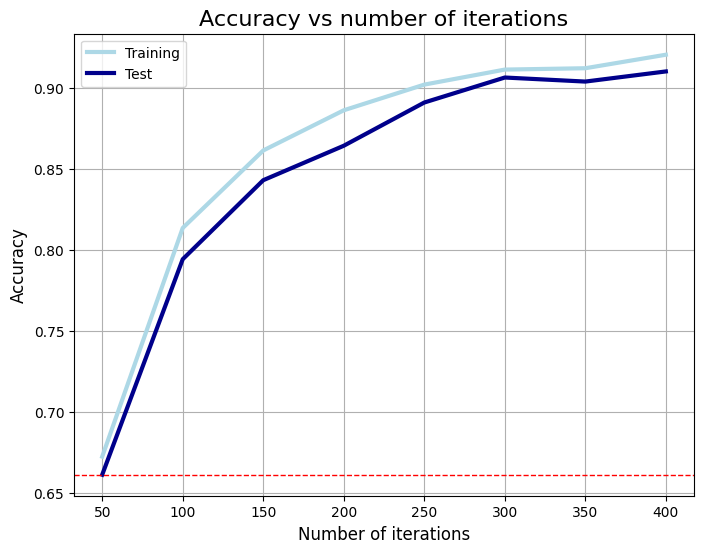

In [68]:
#### DO NOT CHANGE CODE ####

## First, read the dataset
x,y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y
print('Reading Data ...')

# Split into training and test set
train, test = train_test_split(df, test_size=0.2) # this function shuffles the data points, and splits the data into
                                                  # 80% training set and 20% test set (indicated by test_size=0.2)


X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, :-1], test.iloc[:, -1]
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth=1, random_state=1)

# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
acc_train, acc_test = [],[]
x_range = range(10, 410, 50)
for i in x_range:
    print('Number of Iterations : ' , i)
    acc_i = adaboost_classifier(Y_train, X_train, Y_test, X_test, i, clf_tree)
    acc_train.append(acc_i[0])
    acc_test.append(acc_i[1])

# Compare error rate vs number of iterations
utils.plot_accuracy(acc_train, acc_test)

### Question 2:
Justify why the plot is the way it is (is it increasing or decreasing? why? when does it flattens out?)

In [ ]:
'''
    Your answer:
    
The accuracy significantly increases as we increase the number of iterations. After each iteration, 
the weights are updated using more realistic values and then the predictions are updated to more 
realistic labels. So, the more number of iterations, the better accuracy and less error you get, 
As boosting iterations proceed the error rate steadily decreases and the accuracy steadily increases.    
'''

### Question 3

The number of iterations (T) is what we call a hyper parameter:
   - Its value differs from model to model and from problem to problem.
   - Its value is not learnt by time, it is set by the programmer.
   
Suggest ways to select the optimal T keeping in mind that:
   - If T is too big, the training time is large (you loop for T times, each time takes a model to fit and this model might take hours to fit)
   - If T is too small, the boosting might not reach the best values it can get.
   
   

**HINT**: Look at the graph of number of iterations vs performance and search for elbow method. Try to understand it and explain what it does.\
**HINT**: There are other hyper-parameter selection techniques, search for them as well.

In [ ]:
'''
    Your answer:
     1. The Elbow Method: a method is used in Kmeans, PCA, AdaBoost, ...etc
        - To determine the optimal number of iterations, we have to select the value of T at the “elbow”
        ==> the point after which the distortion/inertia start decreasing in a linear fashion.
        Depending on the graph, the proper number of iterations T = 350 iterations
    2. Information–theoretic approach
        - Run the AdaBoost classifier for all T between 1 to n.
        - Calculate the distortion
        - The distortion curve is then transformed by a negative power chosen based on the dimensionality of the data.
        - Jumps in the resulting values then signify reasonable choices for T, with the largest jump representing the best choice.
'''